# Sprint11課題 深層学習スクラッチディープニューラルネットワーク

## スクラッチによる実装
NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

前回作成した3層のニューラルネットワークを、クラスを活用することで、任意の構成に拡張しやすいコードに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。

このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。

### 新たなニューラルネットワーク分類器のクラスを作成する
Sprint9で作成したものとは別に、ニューラルネットワーク分類器のクラスScratchDeepNeuralNetrowkClassifierを作成してください。

### 層などのクラス化
コーディング

クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。

手を加える箇所

層の数
層の種類（今後は畳み込み層など他のタイプの層が登場する）
活性化関数の種類
重みやバイアスの初期化方法
最適化手法
そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。

実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用する。それぞれのクラスについてはこのあと解説します。

サンプルコード1

（ScratchDeepNeuralNetrowkClassifierのfitメソッド内）

```
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数

optimizer = SGD(self.lr)
self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
self.activation1 = Tanh()
self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
self.activation2 = Tanh()
self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
self.activation3 = Softmax()
```

サンプルコード2

（イテレーションごとのフォワード）

```
A1 = self.FC1.forward(X)
Z1 = self.activation1.forward(A1)
A2 = self.FC2.forward(Z1)
Z2 = self.activation2.forward(A2)
A3 = self.FC3.forward(Z2)
Z3 = self.activation3.forward(A3)
```

サンプルコード3

（イテレーションごとのバックワード）

```
A3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
dZ2 = self.FC3.backward(dA3)
dA2 = self.activation2.backward(dZ2)
dZ1 = self.FC2.backward(dA2)
dA1 = self.activation1.backward(dZ1)
dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
```


In [1]:
#ライブラリのインポート
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
#float型へ
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

#正規化
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [5]:
#データ分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


## 【問題1】全結合層のクラス化
コーディング

全結合層のクラスの雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。

重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。

なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。

また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself = self.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。

初期化方法と最適化手法のクラスについては後述します。

雛形

In [6]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    
    Attribute
    ------------
    self.W : 重み
    self.B : バイアス
    self.H_w : 前のイテレーションまでの勾配の(重み)二乗和(初期値0)
    self.H_b : 前のイテレーションまでの勾配の(バイアス)二乗和(初期値0)
    self.forward_Z : forward時の入力値(backward用に利用)
    self.dW : 重みの勾配
    self.dB : バイアスの勾配
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        #AdaGard用
        self.H_w = 0
        self.H_b = 0
        
        self.forward_Z=None

    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #backfoward用に保存
        self.forward_Z = Z.copy()
        
        A = (Z @ self.W) + self.B
        
        return A
    
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = dA.copy()
        self.dW = self.forward_Z.T @ dA
        
        #[batch_size, n_nodes2] dot [n_nodes2, n_nodes1]
        #→ [batch_size, n_nodes1]
        dZ = dA @ self.W.T 
        
        # 更新
        self = self.optimizer.update(self)
              
        return dZ


## 【問題2】初期化方法のクラス化
前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。

これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

雛形

In [7]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

## 【問題3】最適化手法のクラス化
最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself = self.optimizer.update(self)のように更新できるようにします。こちらも雛形を用意しましたので、必要なコードを書き加えていってください。

これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

雛形

In [8]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.dB.shape[0]
        layer.B -= np.mean(self.lr * layer.dB, axis=0)
        
        return layer

## 【問題4】活性化関数のクラス化
活性化関数もクラス化を行なってください。

上記サンプルコード3ではソフトマックス関数のバックプロパゲーションに交差エントロピー誤差の計算も含む実装を想定しています。

In [9]:
class Sigmoid():
    """
    sigmoidの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.forward_A : forward時の入力値(backward用に利用)
    """
    
    def __init__(self):
        self.forward_A = None
        
    def forward(self, A):
        """
        フォワードプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        #backfoward用に保存
        self.forward_A = A.copy()
        
        Z = 1 / (1 + np.exp(-A))
        
        return Z
    
    def backward(self, dZ):
        """
        バックプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """
        sigmoid_A = 1 / (1 + np.exp(-self.forward_A))
        
        dA = dZ * ((1 - sigmoid_A)  * sigmoid_A)
        
        return dA

In [10]:
class Tanh():
    """
    ハイパボリックタンジェントの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.forward_A : forward時の入力値(backward用に利用)
    """
    
    def __init__(self):
        self.forward_A = None
        
    def forward(self, A):
        """
        フォワードプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        #backfoward用に保存
        self.forward_A = A.copy()
        
        Z = np.tanh(A)
        
        return Z
    
    def backward(self, dZ):
        """
        バックプロパゲーションにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """
        dA = dZ * (1 - (np.tanh(self.forward_A) ** 2))
        
        return dA

In [11]:
class Softmax():
    """
    softmaxの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.cost : 交差エントロピー誤差を格納
    """
    
    def __init__(self):
        self.cost = None
        
    def forward(self, A):
        """
        フォワードにおけるソフトマックスの計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力
        """
        #オーバーフロー対策
        max_A = np.max(A)

        #最大要素を引いてからexpをかけることでオーバーフローを回避
        exp_A = np.exp(A - max_A)

         #分母を計算
        sum_exp_A = np.sum(exp_A, axis=1).reshape(-1, 1)
        
        Z = exp_A / sum_exp_A

        return Z
        
    
    def backward(self, Z, Y):
        """
        バックワードにおけるソフトマックスと交差エントロピー誤差
        
        Parameters
        -----------
        Z : 出力層で計算された出力
        Y : 正解値
        
        Return
        -----------
        dA : 出力

        """
        #交差エントロピー誤差
        self.cost = - np.sum(Y * np.log(Z), axis=1)

        #バックワード(出力層)
        dA = Z - Y
        
        return dA
    


## 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装します。

ReLUは以下の数式です。
$$
% <![CDATA[
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

$x$ : ある特徴量。スカラー

実装上はnp.maximumを使い配列に対してまとめて計算が可能です。

[numpy.maximum — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.maximum.html)

一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
% <![CDATA[
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases} %]]>
$$

数学的には微分可能ではないですが、 $x=0$のとき $0$ とすることで対応しています。

フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [12]:
class Relu():
    """
    ReLUの計算
    
    Parameters
    -----------
    
    Attribute
    -----------
    self.mask : 入力値の0以下を判定するboolリスト
    
    """
    
    def __init__(self):
        self.mask = None     
        
    def forward(self, A):
        """
        フォワードにおける活性化関数の計算
        
        Parameters
        -----------
        A : 活性化関数計算前
        
        Return
        -----------
        Z : 出力

        """
        self.mask = (A <= 0)
        
        Z = A.copy()
        
        Z[self.mask] = 0
        
        return Z
    
    def backward(self, dZ):
        """
        バックワードにおける活性化関数の計算
        
        Parameters
        -----------
        dZ : 活性化関数計算前
        
        Return
        -----------
        dA : 出力

        """
        dZ[self.mask] = 0
        
        dA = dZ.copy()
            
        return dA

## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、一般的に良い初期値の取り方が知られています。

シグモイド関数やハイパボリックタンジェント関数のときはXavierの初期値（またはGlorotの初期値）、ReLUのときはHeの初期値が使われます。

XavierInitializerクラスと、HeInitializerクラスを作成します。

それぞれの初期化方法における $σ$ は次の式で求められます。

「Xavierの初期値」

$$
\sigma = \frac{1}{\sqrt{n}}
$$

$n$ : 前の層のノード数

（論文）

[Glorot, X., & Bengio, Y. (n.d.). Understanding the difficulty of training deep feedforward neural networks.](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

「Heの初期値」

$$
\sigma = \sqrt{\frac{2}{n}}
$$

$n$  : 前の層のノード数

（論文）

[He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.](https://arxiv.org/pdf/1502.01852.pdf)

In [13]:
class XavierInitializer:
    """
    Xavierによる初期化
    
    Parameters
    ----------
    
    """
    
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

In [14]:
class HeInitializer:
    """
    Heによる初期化
    
    Parameters
    ----------
    
    """
    
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1) * np.sqrt(2)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)

        return B

## 【問題7】最適化手法
コーディング

学習率は学習の良し悪しにとって重要なハイパーパラメータであり、これを学習過程で変化させていく方法が現在では一般的です。様々な手法が提案されていますが、今回はその中でも基本的な、AdaGradを実装します。

まず、これまで使ってきたSGDを確認します。

$$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$ : $W_i$に関する損失 $L$ の勾配

$\frac{\partial L}{\partial B_i}$ :$B_i$に関する損失$L$の勾配

$E()$ : ミニバッチ方向にベクトルの平均を計算


続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。

更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和$H$を保存しておき、その分だけ学習率を小さくします。

学習率は重み一つひとつに対して異なることになります。

$$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$$

$H_i$ : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）

$H_i^{\prime}$ : 更新した$H_i$

AdaGradクラスを作成し、上記の数式にもとづいて実装してください。

（論文）

[Duchi JDUCHI, J., & Singer, Y. (2011). Adaptive Subgradient Methods for Online Learning and Stochastic Optimization * Elad Hazan. Journal of Machine Learning Research (Vol. 12).](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)


In [15]:
class AdaGrad:
    """
    AdaGradによる最適化手法
    Parameters
    ----------
    lr : 学習率
    """    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        #重みの更新
        layer.H_w += (layer.dW / layer.dB.shape[0]) ** 2
        layer.W -= self.lr * (1 / np.sqrt(layer.H_w + 1e-7)) * (layer.dW / layer.dB.shape[0])

        #バイアスの更新
        layer.H_b += (layer.dB) ** 2        
        layer.B -= np.mean(self.lr * (1 / np.sqrt(layer.H_b + 1e-7)) * layer.dB)

        
        return layer

### クラスにまとめる

In [16]:
#ライブラリインポート
import numpy as np
from sklearn.preprocessing import OneHotEncoder

class ScratchDeepNeuralNetrowkClassifier():
    """
    Deepニューラルネットワーク分類器

    Parameters
    ----------
    verbose : bool
        学習過程を出力する場合はTrue
    n_nodes1 : int(default:100)
        1層目のノード数
    n_nodes2 : int(default:30)
        2層目のノード数
    n_epochs : int(default:30)
        イテレーション数
    lr : flaot (default:1e-3)
        学習率
    batch : int(default :10)
        ミニバッチの単位数
    sigma : float(default:0.01)
        ガウス分布の標準偏差
    opt : str (default: 'sgd')
        最適化手法。'sgd'、'adagrad'より選択。
    act : str (default : 'relu')
        活性化関数。'relu', 'sigmoid', 'tanh'より選択。

    Attributes
    ----------
    self.loss : ndarray,shape(n_epochs, )
        エポックごとの誤差を格納
    self.val_loss : ndarray,shape(n_epochs, )
        エポックごとの誤差(検証用データ)を格納
    self.n_output : int
        出力層のノード数（クラス数）
    self.n_features : int
        入力層のノード数（特徴量の数）
        
        
    """

    def __init__(self, verbose = True, n_nodes1=100, n_nodes2=30, 
                 n_epochs=30, lr=1e-3, batch=10, sigma=0.01, opt='sgd', act='relu'):

        self.verbose = verbose             #True(default):学習過程を表示、False:非表示
        self.n_nodes1 = n_nodes1        #1層目のノード数(default:100)
        self.n_nodes2 = n_nodes2        #2層目のノード数(default:30)
        self.n_epochs = n_epochs        #エポック数(default:30)
        self.lr = lr                                #学習率(default:1e-3)
        self.batch = batch                   #ミニバッチを行うサイズ(default:10)
        self.sigma = sigma                  #ガウス分布の標準偏差
        self.opt = opt                          #最適化手法('sgd' or 'adagrad')
        self.act = act                          #活性化関数('relu' or 'sigmoid' or 'tanh')
        self.loss = np.zeros(n_epochs)
        self.val_loss = np.zeros(n_epochs)
    
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        #出力層のノード数
        self.n_output = np.unique(y).shape[0]
        
        #正解データをワンホットエンコーディング
        y = self._onehot(y)
        #検証用データもあればワンホット
        if X_val is not None:
            y_val = self._onehot(y_val)


        #入力層のノード数
        self.n_features = X.shape[1]

        #minibatchデータを生成
        train_minibatch = GetMiniBatch(X, y, batch_size=self.batch)
        

        #最適化手法のインスタンスを選択、生成。
        if self.opt == 'sgd':
            optimizer = SGD(self.lr)
        elif self.opt == 'adagrad':
            optimizer = AdaGrad(self.lr)
        
        #活性化関数の選択
        #'relu'の場合、Heにて初期化
        if self.act == 'relu':
        
            #1層目
            #インスタンス生成、重みの初期化
            self.FC1 = FC(self.n_features, self.n_nodes1, HeInitializer(), optimizer)
            self.activation1 = Relu()        

            #２層目
            #インスタンス生成、重みの初期化
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, HeInitializer(), optimizer)
            self.activation2 = Relu()        

            #3層目(出力層)
            #インスタンス生成、重みの初期化
            self.FC3 = FC(self.n_nodes2, self.n_output, HeInitializer(), optimizer)
            self.activation3 = Softmax()

        #'sigmoid'の場合、Xavierにて初期化
        elif self.act == 'sigmoid':
        
            #1層目
            #インスタンス生成、重みの初期化
            self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
            self.activation1 = Sigmoid()        

            #２層目
            #インスタンス生成、重みの初期化
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
            self.activation2 = Sigmoid()        

            #3層目(出力層)
            #インスタンス生成、重みの初期化
            self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
            self.activation3 = Softmax()

        #'tanh'の場合、Xavierにて初期化
        elif self.act == 'tanh':
        
            #1層目
            #インスタンス生成、重みの初期化
            self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(), optimizer)
            self.activation1 = Tanh()        

            #２層目
            #インスタンス生成、重みの初期化
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(), optimizer)
            self.activation2 = Tanh()        

            #3層目(出力層)
            #インスタンス生成、重みの初期化
            self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(), optimizer)
            self.activation3 = Softmax()


        #エポック数だけトレーニングを繰り返す
        for epoch in range(self.n_epochs):
                            
            #引数で設定したminibatch数の単位で学習を行う
            for mini_X, mini_y in train_minibatch:
                X = mini_X.copy()
                Y = mini_y.copy()
                                            
                #フォワードプロパゲーション
                A1 = self.FC1.forward(X)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                                
                #バックプロパゲーション
                dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                    

            ############
            # 評価
            ############
            #誤差を格納
            self.loss[epoch] = np.mean(self.activation3.cost)
                        
            #検証用データが引数にある場合、処理を行う
            if X_val is not None:
                                
                #フォワードプロパゲーション
                A1_val = self.FC1.forward(X_val)
                Z1_val = self.activation1.forward(A1_val)
                A2_val = self.FC2.forward(Z1_val)
                Z2_val = self.activation2.forward(A2_val)
                A3_val = self.FC3.forward(Z2_val)
                Z3_val = self.activation3.forward(A3_val)
                
                #検証用データの交差エントロピー誤差を計算
                cost_val = self._compute_cost(y_val, Z3_val)

                #誤差を格納
                self.val_loss[epoch] = np.mean(cost_val)
                            

            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                #一度だけ、'Cross Entropy Error'を出力
                if epoch == 0:
                    print('Cross Entropy Error')
                    
                #エポックごとのコスト関数を出力
                print('epoch{} : {}'.format(epoch+1, np.mean(self.activation3.cost)))
                
                #検証用データがある場合、そのコスト関数も出力
                if X_val is not None:
                    print('epoch_val{} : {}'.format(epoch+1, np.mean(cost_val)))

        return self


    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        y_pred :  次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        #フォワードプロパゲーション
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        #出力層の確率から、最大値をそのクラスとする
        y_pred = np.argmax(Z3, axis=1)
        
        return y_pred
    
    def _onehot(self, y):
        """
        多クラス分類を行う際のone-hot表現に変換

        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples, )
            サンプル

        Returns
        -------
        y_one_hot : 次の形のndarray, shape (n_samples, n_classes)
            推定結果
        """
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        return y_one_hot
    
    
    #交差エントロピー誤差
    def _compute_cost(self, y, y_pred):

        return - np.sum(y * np.log(y_pred), axis=1)
    
    
    
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

### 最適化・活性化関数の組み合わせにてfittng
※変化を確認するためパラメータはは同一とする

### 最適化：SGD × 活性化 : Sigmoid

In [17]:
sdnnc_sgd_sigmoid = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='sigmoid')

sdnnc_sgd_sigmoid.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 1.852072899517919
epoch_val1 : 1.5500430647451855
epoch2 : 1.1899651651925471
epoch_val2 : 0.7606851832450546
epoch3 : 0.9043184418673104
epoch_val3 : 0.5234389401213907
epoch4 : 0.7787692283881396
epoch_val4 : 0.4282125226445131
epoch5 : 0.705886867559105
epoch_val5 : 0.37732065681363125
epoch6 : 0.6565205854759014
epoch_val6 : 0.34527684708684925
epoch7 : 0.620645926987372
epoch_val7 : 0.3224186376570107
epoch8 : 0.5933621906040643
epoch_val8 : 0.3045145868259454
epoch9 : 0.5718839237942899
epoch_val9 : 0.28955612945514686
epoch10 : 0.5542045910829251
epoch_val10 : 0.27651392022255844
epoch11 : 0.5386401205805271
epoch_val11 : 0.26482752098121115
epoch12 : 0.5238966046122324
epoch_val12 : 0.2541808341970286
epoch13 : 0.5091656318524975
epoch_val13 : 0.24438922986176567
epoch14 : 0.4940667983208291
epoch_val14 : 0.23533679248853956
epoch15 : 0.4785196352890285
epoch_val15 : 0.22694164164899963
epoch16 : 0.462620129432967
epoch_val16 : 0.21913789438040665
e

<function matplotlib.pyplot.show(*args, **kw)>

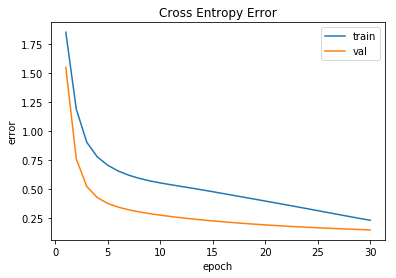

In [18]:
plt.plot(np.arange(1, len(sdnnc_sgd_sigmoid.loss) + 1, 1), sdnnc_sgd_sigmoid.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_sgd_sigmoid.val_loss) + 1, 1), sdnnc_sgd_sigmoid.val_loss, label='val')


plt.title('Cross Entropy Error')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [19]:
print(classification_report(y_val, sdnnc_sgd_sigmoid.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1159
           1       0.98      0.99      0.98      1367
           2       0.95      0.96      0.96      1174
           3       0.95      0.94      0.95      1230
           4       0.96      0.95      0.95      1155
           5       0.95      0.95      0.95      1123
           6       0.95      0.98      0.97      1179
           7       0.97      0.96      0.97      1259
           8       0.94      0.94      0.94      1180
           9       0.94      0.94      0.94      1174

   micro avg       0.96      0.96      0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



### 最適化：SGD × 活性化 : Tanh

In [20]:
sdnnc_sgd_tanh = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='tanh')

sdnnc_sgd_tanh.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.547407018788978
epoch_val1 : 0.3028155974884222
epoch2 : 0.3931063203235792
epoch_val2 : 0.2392713473995997
epoch3 : 0.31667586267765907
epoch_val3 : 0.20036034231859753
epoch4 : 0.2673582217322482
epoch_val4 : 0.17351644543496586
epoch5 : 0.22818087285793034
epoch_val5 : 0.15454659688036831
epoch6 : 0.19219676457380702
epoch_val6 : 0.1406598895286764
epoch7 : 0.15799755337386845
epoch_val7 : 0.13013665037502845
epoch8 : 0.12710936988552402
epoch_val8 : 0.12191424804617138
epoch9 : 0.10001998548606054
epoch_val9 : 0.1152972243075663
epoch10 : 0.076833353857512
epoch_val10 : 0.10985764602488367
epoch11 : 0.05800955927938247
epoch_val11 : 0.10535736083485009
epoch12 : 0.043822981709795816
epoch_val12 : 0.10164324736394606
epoch13 : 0.033723872664203194
epoch_val13 : 0.09856376878892854
epoch14 : 0.026722995685067686
epoch_val14 : 0.09599623020140065
epoch15 : 0.02190380977955674
epoch_val15 : 0.09387524550639723
epoch16 : 0.01856827383017358
epoch_val16 : 0

<function matplotlib.pyplot.show(*args, **kw)>

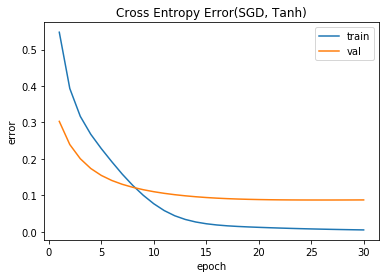

In [21]:
plt.plot(np.arange(1, len(sdnnc_sgd_tanh.loss) + 1, 1), sdnnc_sgd_tanh.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_sgd_tanh.val_loss) + 1, 1), sdnnc_sgd_tanh.val_loss, label='val')


plt.title('Cross Entropy Error(SGD, Tanh)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [22]:
print(classification_report(y_val, sdnnc_sgd_tanh.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1159
           1       0.99      0.99      0.99      1367
           2       0.96      0.98      0.97      1174
           3       0.97      0.97      0.97      1230
           4       0.98      0.97      0.98      1155
           5       0.97      0.98      0.97      1123
           6       0.98      0.98      0.98      1179
           7       0.98      0.97      0.98      1259
           8       0.97      0.96      0.97      1180
           9       0.97      0.97      0.97      1174

   micro avg       0.98      0.98      0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



### 最適化：SGD × 活性化 : ReLU

In [23]:
sdnnc_sgd_relu = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='relu')

sdnnc_sgd_relu.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.36934197328189117
epoch_val1 : 0.24310168556053524
epoch2 : 0.23535948375308183
epoch_val2 : 0.18186322666390872
epoch3 : 0.17940514578986166
epoch_val3 : 0.15193123374995576
epoch4 : 0.1271480443009213
epoch_val4 : 0.13572588409886546
epoch5 : 0.09314260993431564
epoch_val5 : 0.1257938191092597
epoch6 : 0.05974779390398895
epoch_val6 : 0.11765831670805418
epoch7 : 0.05255128781497219
epoch_val7 : 0.11273234748495035
epoch8 : 0.03725334710747991
epoch_val8 : 0.10823689945080567
epoch9 : 0.036436800933604754
epoch_val9 : 0.10549082988838633
epoch10 : 0.029151974771777816
epoch_val10 : 0.10312651976336122
epoch11 : 0.01920017477624731
epoch_val11 : 0.10196559152429192
epoch12 : 0.014882152622890294
epoch_val12 : 0.10126096750935581
epoch13 : 0.013107741091529443
epoch_val13 : 0.10153143521580602
epoch14 : 0.011114937100523015
epoch_val14 : 0.10173471332135864
epoch15 : 0.011234968235082734
epoch_val15 : 0.10207808218592919
epoch16 : 0.008967706878517964
epo

<function matplotlib.pyplot.show(*args, **kw)>

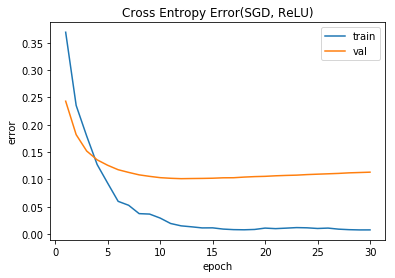

In [24]:
plt.plot(np.arange(1, len(sdnnc_sgd_relu.loss) + 1, 1), sdnnc_sgd_relu.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_sgd_relu.val_loss) + 1, 1), sdnnc_sgd_relu.val_loss, label='val')


plt.title('Cross Entropy Error(SGD, ReLU)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [25]:
print(classification_report(y_val, sdnnc_sgd_relu.predict(X_val)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1159
           1       0.99      0.99      0.99      1367
           2       0.96      0.98      0.97      1174
           3       0.97      0.96      0.97      1230
           4       0.98      0.97      0.98      1155
           5       0.96      0.98      0.97      1123
           6       0.98      0.99      0.98      1179
           7       0.98      0.97      0.98      1259
           8       0.96      0.97      0.96      1180
           9       0.98      0.95      0.97      1174

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### 最適化：AdaGrad × 活性化 : Sigmoid

In [26]:
sdnnc_adagrad_sigmoid = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='adagrad', 
    act='sigmoid')

sdnnc_adagrad_sigmoid.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.9575839814798203
epoch_val1 : 0.40100318845963057
epoch2 : 0.8135210169710358
epoch_val2 : 0.3133572090294604
epoch3 : 0.7344801300333348
epoch_val3 : 0.27590342711801913
epoch4 : 0.6808812664922597
epoch_val4 : 0.2533468035862149
epoch5 : 0.6401975317515607
epoch_val5 : 0.23756467296437062
epoch6 : 0.6072540674103728
epoch_val6 : 0.22556320826342277
epoch7 : 0.5795284157190779
epoch_val7 : 0.21594918391110357
epoch8 : 0.5555703904492482
epoch_val8 : 0.20797283977372522
epoch9 : 0.5344166376273287
epoch_val9 : 0.20118744113630183
epoch10 : 0.5153717600066499
epoch_val10 : 0.19530603944020736
epoch11 : 0.4979168133343713
epoch_val11 : 0.19013344897326048
epoch12 : 0.4816650596641211
epoch_val12 : 0.18553075383622483
epoch13 : 0.466335251527857
epoch_val13 : 0.1813954094358409
epoch14 : 0.45172890790365666
epoch_val14 : 0.17764946386461622
epoch15 : 0.4377091030946672
epoch_val15 : 0.17423225901752126
epoch16 : 0.42418260536416924
epoch_val16 : 0.1710957079

<function matplotlib.pyplot.show(*args, **kw)>

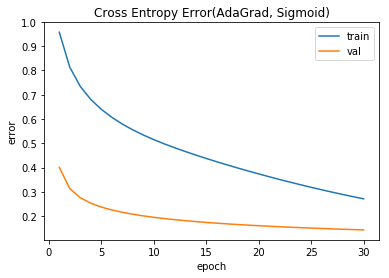

In [27]:
plt.plot(np.arange(1, len(sdnnc_adagrad_sigmoid.loss) + 1, 1), sdnnc_adagrad_sigmoid.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_adagrad_sigmoid.val_loss) + 1, 1), sdnnc_adagrad_sigmoid.val_loss, label='val')


plt.title('Cross Entropy Error(AdaGrad, Sigmoid)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [28]:
print(classification_report(y_val, sdnnc_adagrad_sigmoid.predict(X_val)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1159
           1       0.98      0.98      0.98      1367
           2       0.95      0.96      0.96      1174
           3       0.95      0.94      0.94      1230
           4       0.97      0.96      0.96      1155
           5       0.96      0.95      0.95      1123
           6       0.96      0.98      0.97      1179
           7       0.97      0.96      0.97      1259
           8       0.94      0.94      0.94      1180
           9       0.94      0.94      0.94      1174

   micro avg       0.96      0.96      0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



### 最適化：AdaGrad × 活性化 : Tanh

In [29]:
sdnnc_adagrad_tanh = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='adagrad', 
    act='tanh')

sdnnc_adagrad_tanh.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.5493163408601469
epoch_val1 : 0.2258760180267524
epoch2 : 0.4324456397951626
epoch_val2 : 0.1851848167890548
epoch3 : 0.35770330214188945
epoch_val3 : 0.16397080719277285
epoch4 : 0.305678700845662
epoch_val4 : 0.15034288976789506
epoch5 : 0.26495908176897665
epoch_val5 : 0.140632288938806
epoch6 : 0.23135046440288418
epoch_val6 : 0.13328033133560713
epoch7 : 0.20323866796451875
epoch_val7 : 0.127478598029426
epoch8 : 0.1796182514258345
epoch_val8 : 0.12275574167966964
epoch9 : 0.15966225161343345
epoch_val9 : 0.11881667296788931
epoch10 : 0.1426969004750525
epoch_val10 : 0.11546752793209597
epoch11 : 0.12819983767255913
epoch_val11 : 0.11257586245042972
epoch12 : 0.11576825623205786
epoch_val12 : 0.11004779359714509
epoch13 : 0.10508476791058055
epoch_val13 : 0.10781463592148814
epoch14 : 0.09589153134432586
epoch_val14 : 0.10582494962650885
epoch15 : 0.08797310564991198
epoch_val15 : 0.10403945384721679
epoch16 : 0.08114617341339633
epoch_val16 : 0.1024

<function matplotlib.pyplot.show(*args, **kw)>

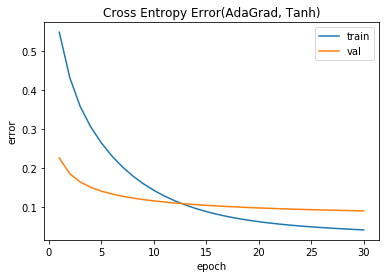

In [30]:
plt.plot(np.arange(1, len(sdnnc_adagrad_tanh.loss) + 1, 1), sdnnc_adagrad_tanh.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_adagrad_tanh.val_loss) + 1, 1), sdnnc_adagrad_tanh.val_loss, label='val')


plt.title('Cross Entropy Error(AdaGrad, Tanh)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [31]:
print(classification_report(y_val, sdnnc_adagrad_tanh.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1159
           1       0.99      0.99      0.99      1367
           2       0.97      0.97      0.97      1174
           3       0.97      0.96      0.96      1230
           4       0.97      0.97      0.97      1155
           5       0.97      0.98      0.97      1123
           6       0.98      0.98      0.98      1179
           7       0.98      0.97      0.98      1259
           8       0.96      0.96      0.96      1180
           9       0.96      0.96      0.96      1174

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### 最適化：AdaGrad × 活性化 : ReLU

In [32]:
sdnnc_adagrad_relu = ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=30, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='adagrad', 
    act='relu')

sdnnc_adagrad_relu.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.2834447146594833
epoch_val1 : 0.1849309338011388
epoch2 : 0.21000753564351599
epoch_val2 : 0.154630341017838
epoch3 : 0.15885876437508528
epoch_val3 : 0.13821654203657968
epoch4 : 0.12407148086013302
epoch_val4 : 0.12811362994195838
epoch5 : 0.09896418293373073
epoch_val5 : 0.12143017122914652
epoch6 : 0.07971311505168317
epoch_val6 : 0.11621692018471613
epoch7 : 0.0676946581811539
epoch_val7 : 0.11237388418809417
epoch8 : 0.05876090888073352
epoch_val8 : 0.10932804289031221
epoch9 : 0.05163486116219684
epoch_val9 : 0.10680527516544631
epoch10 : 0.048958846733819485
epoch_val10 : 0.10467535576713642
epoch11 : 0.046174816208945105
epoch_val11 : 0.10295928408047983
epoch12 : 0.0434141541372687
epoch_val12 : 0.10136152128194473
epoch13 : 0.04204053611896903
epoch_val13 : 0.10009595069369936
epoch14 : 0.04210829094646776
epoch_val14 : 0.0989800345805567
epoch15 : 0.04034385584854867
epoch_val15 : 0.09801865901465519
epoch16 : 0.03884891513012671
epoch_val16 :

<function matplotlib.pyplot.show(*args, **kw)>

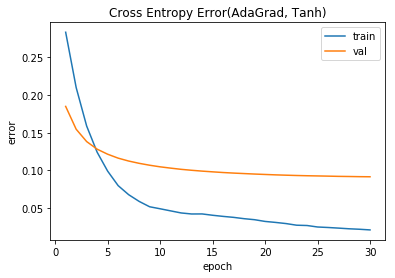

In [33]:
plt.plot(np.arange(1, len(sdnnc_adagrad_relu.loss) + 1, 1), sdnnc_adagrad_relu.loss, label='train')
plt.plot(np.arange(1, len(sdnnc_adagrad_relu.val_loss) + 1, 1), sdnnc_adagrad_relu.val_loss, label='val')


plt.title('Cross Entropy Error(AdaGrad, Tanh)')
plt.xlabel('epoch')
plt.ylabel('error')

plt.legend()
plt.show

In [34]:
print(classification_report(y_val, sdnnc_adagrad_relu.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1159
           1       0.99      0.99      0.99      1367
           2       0.97      0.97      0.97      1174
           3       0.97      0.96      0.97      1230
           4       0.98      0.97      0.97      1155
           5       0.96      0.98      0.97      1123
           6       0.98      0.98      0.98      1179
           7       0.98      0.97      0.98      1259
           8       0.95      0.97      0.96      1180
           9       0.97      0.96      0.97      1174

   micro avg       0.97      0.97      0.97     12000
   macro avg       0.97      0.97      0.97     12000
weighted avg       0.97      0.97      0.97     12000



### pyファイルで確認

In [35]:
#pyファイル格納ディレクトリのパス設定
import sys
sys.path.append("/Users/yusuke-saruya/diveintocode-ml/full-time/diveintocode-term2/ml-scratch/utils/")
import deepneuralnetrowk


In [36]:
sdnnc_py = deepneuralnetrowk.ScratchDeepNeuralNetrowkClassifier(
    verbose = True, 
    n_nodes1=100, 
    n_nodes2=30, 
    n_epochs=5, 
    lr=1e-2, 
    batch=10, 
    sigma=0.01, 
    opt='sgd', 
    act='relu')

sdnnc_py.fit(X_train, y_train, X_val, y_val)

Cross Entropy Error
epoch1 : 0.36934197328189117
epoch_val1 : 0.24310168556053524
epoch2 : 0.23535948375308183
epoch_val2 : 0.18186322666390872
epoch3 : 0.17940514578986166
epoch_val3 : 0.15193123374995576
epoch4 : 0.1271480443009213
epoch_val4 : 0.13572588409886546
epoch5 : 0.09314260993431564
epoch_val5 : 0.1257938191092597
